In [1]:
import asyncio
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

from tqdm import tqdm
from web3 import Web3
from web3.eth import AsyncEth

In [2]:
TOPICS = [
    "0x8d685bd3f45d861c759ed7a46ea3d30eb5cc6ce9fe06c526931f94c963bca7d2",  # Provide
    "0x5b6b431d4476a211bb7d41c20d1aab9ae2321deee0d20be3d9fc9b1093fa6e3d",  # Withdraw
]
PEG_KEEPERS = {
    "USDC": "0xaA346781dDD7009caa644A4980f044C50cD2ae22",
    "USDT": "0xE7cd2b4EB1d98CD6a4A48B6071D46401Ac7DC5C8",
    "USDP": "0x6B765d07cf966c745B340AdCa67749fE75B5c345",
    "TUSD": "0x1ef89Ed0eDd93D1EC09E4c07373f69C49f4dcCae",
}
START = max(
    17258049,
    17258037,
    17258043,
    17258049,
)
END = 0  # 0 for latest block

COLORS={
    "USDC": "#3E73C4",
    "USDT": "#6BAC95",
    "USDP": "#E4E059",
    "TUSD": "#2E59F6",
}

In [3]:
web3 = Web3(
    provider=Web3.AsyncHTTPProvider(
        f"https://eth-mainnet.alchemyapi.io/v2/{'2-IfLb65aNYkuy0RQ4lCHOkWXsDAM-yK' or os.environ['WEB3_ETHEREUM_MAINNET_ALCHEMY_API_KEY']}",
        {"verify_ssl": False}
    ),
    modules={"eth": (AsyncEth,)},
    middlewares=[],
)

In [4]:
async def fetch_logs():
    global END
    if END == 0:
        END = await web3.eth.block_number
    print(f"Querying through {END - START} blocks")
    entries = []
    for topic in TOPICS:
        entries.extend(await web3.eth.get_logs(
            {
                "fromBlock": START - 2000,
                "toBlock": END,
                "address": list(PEG_KEEPERS.values()),
                "topics": [topic],
            }
        ))
    entries.sort(key=lambda log: log["blockNumber"])  # Action_delay allows us to do this
    return entries

async def fetch_debt_ceilings():
    global END
    if END == 0:
        END = await web3.eth.block_number
    return await web3.eth.get_logs(
        {
            "fromBlock": START - 2000,
            "toBlock": END,
            "address": ["0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC"],
            "topics": ["0x22d26e5448456e0d2368bca46b2c824717b39390656f1c6314237e11d691e4f2"],  # SetDebtCeiling
        }
    )

In [5]:
amounts_entries = await fetch_logs()
print(f"Fetched {len(amounts_entries)} logs")
ceilings_entries = await fetch_debt_ceilings()
print(f"Fetched {len(ceilings_entries)} ceiling changes")

Querying through 1175447 blocks
Fetched 565 logs
Fetched 16 ceiling changes


In [6]:
def get_amounts(entries):
    amounts = {pk: [] for pk in PEG_KEEPERS.values()}
    for log in entries:
        pk_address = str(log["address"])
        amounts[pk_address].append((
            log["blockNumber"],
            int(log["data"].hex(), base=16) * (-1 if log['topics'][0].hex() == TOPICS[1] else 1),  # -1 for Withdraw
        ))
    return amounts

def retrieve_address(data):
    if isinstance(data, str):
        return Web3.to_checksum_address("0x" + data[-40:])
    else:
        return retrieve_address(data.hex())

def get_ceilings(ceilings):
    amounts = {pk: [] for pk in PEG_KEEPERS.values()}
    for log in ceilings:
        c_address = retrieve_address(log["topics"][1])
        if c_address in PEG_KEEPERS.values():
            amounts[c_address].append((
                log["blockNumber"],
                int(log["data"].hex(), base=16),
            ))
    return amounts

In [7]:
amounts = get_amounts(amounts_entries)
ceilings = get_ceilings(ceilings_entries)

In [8]:
# Unfold all block numbers
block_nums = list(sorted(set(
    [amount[0] for pk_amounts in amounts.values() for amount in pk_amounts] +
    [ceiling[0] for pk_ceilings in ceilings.values() for ceiling in pk_ceilings]
)))
cum_sums = []
for addr in PEG_KEEPERS.values():
    cum_sums.append([])
    cum_sum = 0
    cur_iter = iter(amounts[addr] + [(np.inf, 0)])
    next_amount = next(cur_iter)
    assert next_amount == amounts[addr][0]
    for block_num in block_nums:
        if block_num == next_amount[0]:
            cum_sum += next_amount[1]
            next_amount = next(cur_iter)
        cum_sums[-1].append(cum_sum / 10 ** 18)

cum_sums = np.array(cum_sums)

In [9]:
# We don't mind hourly errors
# Errors occur from empty slots in POS
block_timestamps = [(await web3.eth.get_block(block_nums[0]))["timestamp"]]
prev_block, prev_ts = block_nums[0], block_timestamps[0]
for block in tqdm(block_nums[1:]):
    if block - prev_block >= 24 * 3600 // 12:  # fetch ~ every day
        ts = (await web3.eth.get_block(block))["timestamp"]
        prev_block, prev_ts = block, ts
    else:
        ts = prev_ts + 12 * (block - prev_block)
    block_timestamps.append(ts)

# Too long
async def fetch_timestamps(block_nums):
    return [web3.eth.get_block(block_id)["timestamp"] for block_id in block_nums]

# timestamps = await fetch_timestamps(block_nums)
# counts, bins = np.histogram(np.array(timestamps) - np.array(block_timestamps))
# plt.hist(bins[:-1], bins, weights=counts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:12<00:00, 44.49it/s]


In [10]:
block_dates = mdates.date2num([dt.datetime.fromtimestamp(ts) for ts in block_timestamps])

In [11]:
def plot(cum_values, ax=plt, title="Peg Keepers' debt distribution", ylabel="USD"):
    ax.stackplot(
        block_dates, cum_values,
        labels=PEG_KEEPERS.keys(),
        colors=[COLORS[coin] for coin in PEG_KEEPERS.keys()],
        step='post',
    )
    if ax != plt:
        ax.set(ylabel=ylabel)
    else:
        plt.title(title)
        plt.ylabel(ylabel)
        plt.legend()
        ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

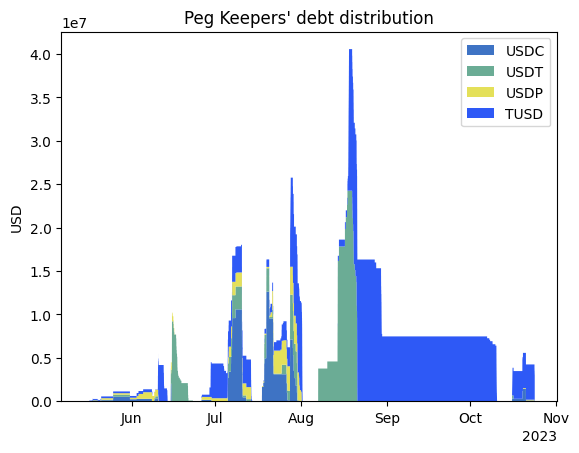

In [12]:
plot(cum_sums)

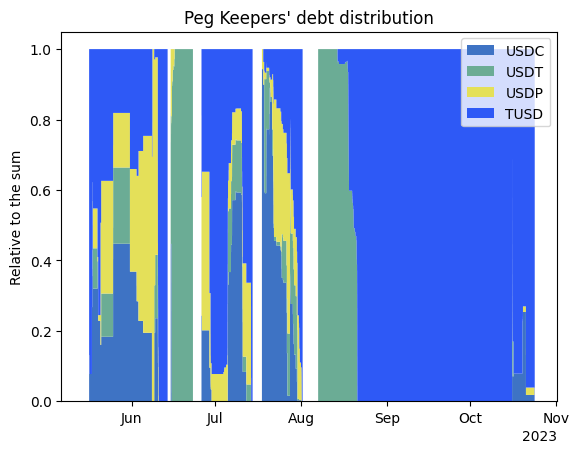

In [13]:
sums = np.sum(cum_sums, axis=0)
sums[sums == 0] = 1
cum_sums_relative = cum_sums / sums
plot(cum_sums_relative, ylabel="Relative to the sum")

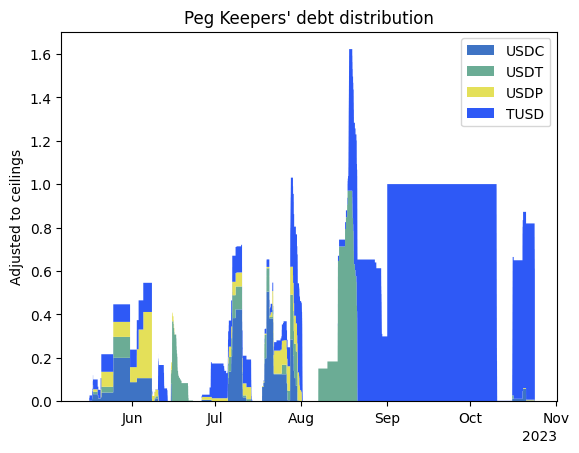

In [14]:
cum_ceilings = []
for i, addr in enumerate(PEG_KEEPERS.values()):
    cum_ceilings.append([])
    cum_ceiling = 1
    cur_iter = iter(ceilings[addr] + [(np.inf, 0)])
    next_ceiling = next(cur_iter)
    assert next_ceiling == ceilings[addr][0]
    for j, block_num in enumerate(block_nums):
        if block_num == next_ceiling[0]:
            cum_ceiling = next_ceiling[1]
            next_ceiling = next(cur_iter)
        cum_ceilings[-1].append(
#             cum_ceiling / 10 ** 18
            max(cum_ceiling / 10 ** 18, cum_sums[i][j])
        )

cum_sums_adjusted = cum_sums / cum_ceilings
plot(cum_sums_adjusted, ylabel="Adjusted to ceilings")

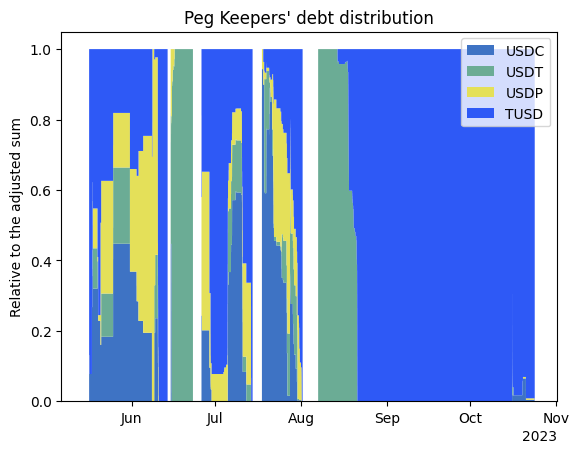

In [15]:
sums_adjusted = np.sum(cum_sums_adjusted, axis=0)
sums_adjusted[sums_adjusted == 0] = 1
cum_sums_adjusted_relative = cum_sums_adjusted / sums_adjusted
plot(cum_sums_adjusted_relative, ylabel="Relative to the adjusted sum")

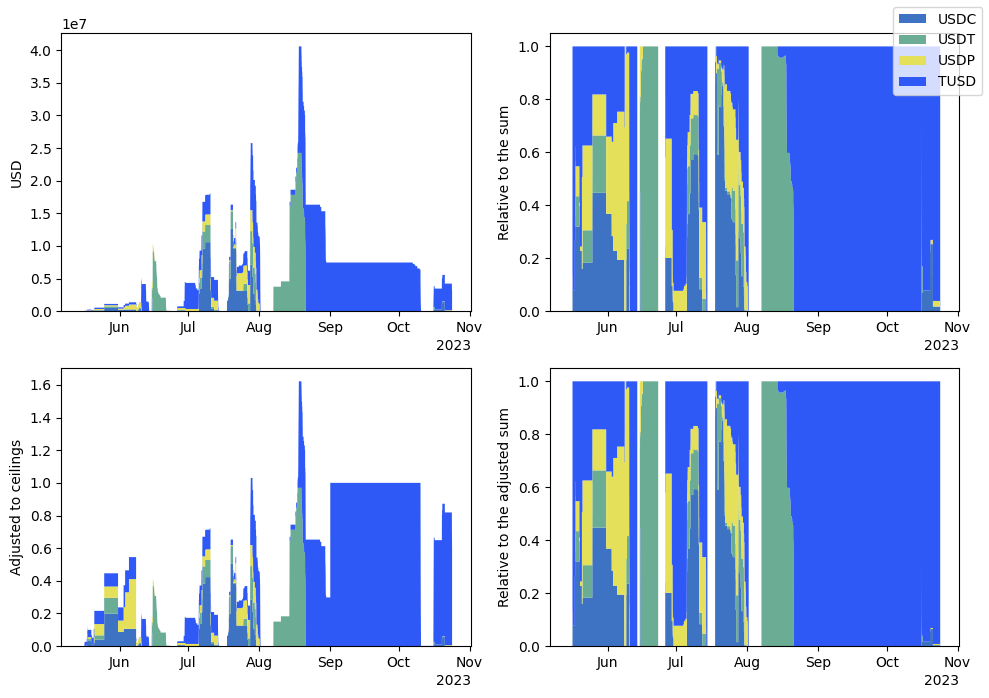

In [16]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 7))
plot(cum_sums, ax=axarr[0,0])
plot(cum_sums_relative, ylabel="Relative to the sum", ax=axarr[0,1])
plot(cum_sums_adjusted, ylabel="Adjusted to ceilings", ax=axarr[1,0])
plot(cum_sums_adjusted_relative, ylabel="Relative to the adjusted sum", ax=axarr[1,1])

handles, labels = axarr[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()

In [17]:
alpha = 1 / 2
beta = 1 / 4
def max_ratio(ratios, i = 0):
    ratios = np.array([ratio for j, ratio in enumerate(ratios) if j != i])
    return min((alpha + beta * sum(np.sqrt(ratios))) ** 2, 1)

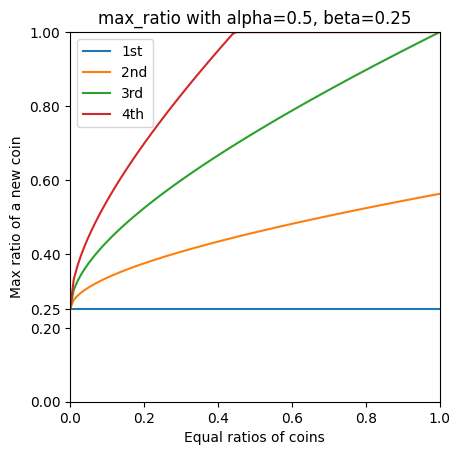

In [18]:
xs = np.arange(0, 1.00001, 0.01)
plt.plot(
    xs,
    [max_ratio([0, 0, 0, 0]) for x in xs],
    label="1st",
)
plt.plot(
    xs,
    [max_ratio([0, x, 0, 0]) for x in xs],
    label="2nd",
)
plt.plot(
    xs,
    [max_ratio([0, x, x, 0]) for x in xs],
    label="3rd",
)
plt.plot(
    xs,
    [max_ratio([0, x, x, x]) for x in xs],
    label="4th",
)

plt.xlim(0, 1)
plt.ylim(0, 1)

ax = plt.gca()
ax.set_yticks(np.append(ax.get_yticks(), max_ratio([0, 0, 0, 0])))
ax.set_aspect('equal', adjustable='box')

plt.xlabel("Equal ratios of coins")
plt.ylabel("Max ratio of a new coin")
plt.title(f"max_ratio with alpha={alpha}, beta={beta}")
plt.legend()

plt.show()
# plt.savefig(f"max_ratio_{alpha}_{beta}.png")